# **Preparation of PIMUS Network for GTAModel**

## **General pipeline overview**

![methology](imgs/pipeline.jpg)

## **Pipeline**

### **Cleaning processs**

#### Cleaning proposals

* **Import modules**

In [49]:
#import cudf
#import cuspatial
#import cupy
import geopandas
from glob import glob
import pandas as pd
import numpy as np
from shapely.geometry import *
from shapely import wkt
import zipfile
#local import
from Converters import Converters 

* **Convert Net file to csv's**

In [50]:
#unzip the Network file
!unzip NetModel/BaseVisumProject/network.zip
#create dir to export csv
!mkdir Base_Network
conv = Converters()
#convert .net to csv in the created dir
conv.net2csv('network.net','Base_Network/')

Archive:  NetModel/BaseVisumProject/network.zip
  inflating: network.net             


Parsing table:  Versionblock
Use delimiter ";"
Exported 1 objects in table: Versionblock - saved to Base_Network/Versionblock.csv
Parsing table:  User-definedattributes
Exported 151 objects in table: User-definedattributes - saved to Base_Network/User-definedattributes.csv
Parsing table:  Time-varyingattributes
Exported 1 objects in table: Time-varyingattributes - saved to Base_Network/Time-varyingattributes.csv
Parsing table:  Calendarperiods
Exported 1 objects in table: Calendarperiods - saved to Base_Network/Calendarperiods.csv
Parsing table:  Validdays
Exported 1 objects in table: Validdays - saved to Base_Network/Validdays.csv
Parsing table:  Network
Exported 1 objects in table: Network - saved to Base_Network/Network.csv
Parsing table:  Transportsystems
Exported 19 objects in table: Transportsystems - saved to Base_Network/Transportsystems.csv
Parsing table:  Modes
Exported 7 objects in table: Modes - saved to Base_Network/Modes.csv
Parsing table:  Demandsegments
Exported 12 obj

* **Load all objects as dataframes**

In [51]:
objDFs = {(f.split('/')[-1]).split('.')[0]: pd.read_csv(f) for f in glob('Base_Network/*.csv')}
list(objDFs.keys())

/tmp/ipykernel_5936/3508830712.py:1: DtypeWarning: Columns (242,266,267) have mixed types. Specify dtype option on import or set low_memory=False.
  objDFs = {(f.split('/')[-1]).split('.')[0]: pd.read_csv(f) for f in glob('Base_Network/*.csv')}


['Transferwalktimesbetweenstopareas',
 'Faceitems',
 'Modes',
 'Lineroutes',
 'Operators',
 'Edges',
 'Transferfares',
 'Blockitemtypes',
 'Timeprofiles',
 'Validdays',
 'Turns',
 'Mainzones',
 'Linktypes',
 'Zones',
 'Calendarperiods',
 'Surfaces',
 'Linerouteitems',
 'User-definedattributes',
 'Timeprofileitems',
 'Stoppoints',
 'Blockversions',
 'Stops',
 'Connectors',
 'Faremodel',
 'Stopareas',
 'Tickettypes',
 'Faces',
 'PuTdirections',
 'Intermediatepoints',
 'Faresystems',
 'Nodes',
 'Lines',
 'Links',
 'Network',
 'Demandsegments',
 'Time-varyingattributes',
 'Aliases',
 'Transportsystems',
 'Surfaceitems',
 'Vehiclecombinationitems',
 'Vehiclejourneys',
 'Points',
 'Versionblock',
 'FaresystemtickettypesbyDSeg',
 'Faresupplements',
 'Vehiclejourneysections',
 'Vehiclecombinations',
 'Linkpolygons',
 'Vehicleunits']

In [52]:
!nvidia-smi

Tue Oct 10 14:01:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P0              20W /  60W |      6MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

* **Filter all the objects with TSys proposals information**

In [53]:
# extract objects with the TSys proposals
props = ['tren_aero', 'regional', 'tren', 'corredor','alimentadora corredor']
# get the files to modify where the TSys appear
p = !grep -lR "Corredor"
# remove non csv files and get the key name
kPropFiles = [(v.split('/')[-1]).split('.')[0] for v in p if v.endswith(".csv")]
print(f'[INFO] Objects to clean: {kPropFiles}')

[INFO] Objects to clean: ['Faresystems', 'Transportsystems']


In [54]:
# extract codes of the proposals TransportSystems 
objWcode = [k for k in kPropFiles if 'CODE' in objDFs[k].columns.tolist()]
cProps = [list((objDFs[o][objDFs[o]['NAME'].str.lower() == p].CODE).to_dict().values()) for p in props for o in objWcode]
cProps = [c[0] for c in cProps if len(c) > 0] 
cProps += ['Ca_BD', 'Cu_BD']
print(cProps)
# extract no. of the proposals TransportSystems 
objWno = list(set(kPropFiles) - set(objWcode))
nProps = [list((objDFs[o][objDFs[o]['NAME'].str.lower() == p].NO).to_dict().values()) for p in props for o in objWno]
nProps = [n[0] for n in nProps if len(n) > 0] 
nProps

['RE', 'S', 'C', 'AC', 'Ca_BD', 'Cu_BD']


[13, 12, 11, 10, 9]

In [55]:
def cleanByList(df,column: str, values: list):
    for v in values:
        df = df[df[column].str.lower() != v]
    return df
    
for k in kPropFiles:
#cleaning objects by TSys proposals names
    objDFs[k] = cleanByList(objDFs[k],'NAME', props)
objDFs[kPropFiles[0]]

NO          NAME  RANK  JOINTFARECOMPUTATION  FAREWEIGHT  INITIALFARE  \
0   1  Alimentadora     1                     0         1.0         12.0   
1   2         Metro     1                     0         1.0          4.5   
2   3     Remanente     1                     0         1.0         12.0   
3   4           BRT     1                     0         1.0         14.6   
4   5            TM     1                     0         1.0          4.5   
5   6          MBUS     1                     0         1.0         12.0   
6   7  Remanente 15     1                     0         1.0         15.0   
7   8  Remanente 17     1                     0         1.0         17.0   

   TSYSSETNONPUTLINE\n  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN

In [56]:
def BD_clean(s):
    tsys = s.strip().split(',')
    if ('Ca_BD') in tsys and ('Ca1_C' not in tsys and 'Ca2_C' not in tsys):
        tsys[tsys.index('Ca_BD')] = 'Ca1_C'
    if ('Cu_BD') in tsys and ('Cu_C' not in tsys):
        tsys[tsys.index('Cu_BD')] = 'Cu_C'
    return ','.join(tsys)

def cleanBycode(s:str) -> str:
    tsys = s.strip().split(',')
    if isinstance(s,str):
        if len(s.split(',')) >0:
            return ','.join(set (tsys) - set (cProps))
    return s


#cleaning objects by TSys proposals codes and removing nulls
objWtsset = [k for k in objDFs.keys() if 'TSYSSET' in objDFs[k].columns.tolist()]
print(f'[INFO] Objects to clean: {objWtsset}')
print(objDFs[objWtsset[0]])
for o in objWtsset:
    objDFs[o] = objDFs[o][~objDFs[o]['TSYSSET'].isnull()]
    if o != 'Modes':
        objDFs[o]['TSYSSET'] = objDFs[o]['TSYSSET'].apply(BD_clean)
    objDFs[o]['TSYSSET'] = objDFs[o]['TSYSSET'].apply(cleanBycode)
    objDFs[o] = objDFs[o].query('TSYSSET != ""')
objDFs[objWtsset[0]] 

[INFO] Objects to clean: ['Modes', 'Turns', 'Linktypes', 'Stoppoints', 'Connectors', 'Links', 'Vehicleunits']
     CODE                        NAME                              TSYSSET  \
0  Auto_C                  Auto Cuota                               Auto_C   
1   Ca1_C     Ca1 Camion articulado 1                                Ca1_C   
2   Ca2_C     Ca2 Camion articulado 2                                Ca2_C   
3   Ca_BD  Camion articulado Big Data                                Ca_BD   
4   Cu_BD    Camion unitario Big Data                                Cu_BD   
5    Cu_C          Cu Camion unitario                                 Cu_C   
6     Pub                     Publico  AC,Al,C,Ex,M,MBUS,R,RAE,RE,S,T,TM,W   

   INTERCHANGEABLE\n  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
5                  1  
6                  1  


CODE                     NAME                    TSYSSET  \
0  Auto_C               Auto Cuota                     Auto_C   
1   Ca1_C  Ca1 Camion articulado 1                      Ca1_C   
2   Ca2_C  Ca2 Camion articulado 2                      Ca2_C   
5    Cu_C       Cu Camion unitario                       Cu_C   
6     Pub                  Publico  RAE,M,Ex,Al,W,R,TM,T,MBUS   

   INTERCHANGEABLE\n  
0                  1  
1                  1  
2                  1  
5                  1  
6                  1

In [57]:
#cleaning proposals from objects by faresystemno
objWfsno = {k: [c for c in objDFs[k].columns.tolist() if 'FARESYSTEMNO' in c] for k in objDFs.keys() if len([c for c in objDFs[k].columns.tolist() if 'FARESYSTEMNO' in c]) > 0}
print(f'[INFO] Objects to clean: {objWfsno}')
for o in objWfsno.keys():
    for c in objWfsno[o]:
        objDFs[o] = objDFs[o][~objDFs[o][c].isnull()]
        objDFs[o] = objDFs[o][~objDFs[o][c].isin(nProps)]
    print(objDFs[o].head())

[INFO] Objects to clean: {'Transferfares': ['FROMFARESYSTEMNO', 'TOFARESYSTEMNO'], 'FaresystemtickettypesbyDSeg': ['FARESYSTEMNO\n']}
   FROMFARESYSTEMNO  TOFARESYSTEMNO  FARE\n
0                 1               1    12.0
1                 1               2     4.5
2                 1               3    12.0
3                 1               4    14.6
4                 1               5    12.0
   TICKETTYPENO DSEGCODE  FARESYSTEMNO\n
0             1       P1               1
1             1       P2               1
2             1       P3               1
3             1       P1               2
4             1       P2               2


In [58]:
#cleaning proposals from objects by faresystemcode

objWfscd = {k: [c for c in objDFs[k].columns.tolist() if 'SYSCODE' in c] for k in objDFs.keys() if len([c for c in objDFs[k].columns.tolist() if 'SYSCODE' in c]) > 0}
print(f'[INFO] Objects to clean: {objWfscd}')
for o in objWfscd.keys():
    for c in objWfscd[o]:
        objDFs[o] = objDFs[o][~objDFs[o][c].isnull()]
        objDFs[o] = objDFs[o][~objDFs[o][c].isin(cProps)]
    print(objDFs[o].head())

[INFO] Objects to clean: {'Transferwalktimesbetweenstopareas': ['TSYSCODE'], 'Lines': ['TSYSCODE'], 'Faresupplements': ['TSYSCODE']}
   FROMSTOPAREANO  TOSTOPAREANO TSYSCODE TIME\n
0            2329          2329        W     0s
1            2330          2330        W     0s
2            2336          2336        W     0s
3            2354          2354        W     0s
4            2363          2363        W     0s
    NAME TSYSCODE  VEHCOMBNO  FARESYSTEMSET  OPERATORNO  MAINLINENAME  \
0    R_1        R          1              3           1           NaN   
1   R_10        R          1              3           1           NaN   
2  R_100        R          1              3           1           NaN   
3  R_101        R          1              3           1           NaN   
4  R_102        R          1              3           1           NaN   

   ADDVAL1  ADDVAL2  ADDVAL3\n  
0        0        0          0  
1        0        0          0  
2        0        0          0  
3       

#### Cleaning Links

* **Read and filter links for walk only not associated with stops** 

In [59]:
objDFs['Links'].columns.values

array(['NO', 'FROMNODENO', 'TONODENO', 'NAME', 'TYPENO', 'TSYSSET',
       'USERDIRECTION', 'LENGTH', 'NUMLANES', 'PLANNO', 'CAPPRT', 'V0PRT',
       'T_PUTSYS(AC)', 'T_PUTSYS(AL)', 'T_PUTSYS(C)', 'T_PUTSYS(EX)',
       'T_PUTSYS(M)', 'T_PUTSYS(MBUS)', 'T_PUTSYS(R)', 'T_PUTSYS(RAE)',
       'T_PUTSYS(RE)', 'T_PUTSYS(S)', 'T_PUTSYS(T)', 'T_PUTSYS(TM)',
       'T_PUTSYS(W)', 'TMODELSPECIAL', 'TMODELMAINNODESPECIAL', 'ADDVAL1',
       'ADDVAL2', 'ADDVAL3', 'ADDVAL_TSYS(AC)', 'ADDVAL_TSYS(AL)',
       'ADDVAL_TSYS(AUTO_C)', 'ADDVAL_TSYS(C)', 'ADDVAL_TSYS(CA1_C)',
       'ADDVAL_TSYS(CA2_C)', 'ADDVAL_TSYS(CA_BD)', 'ADDVAL_TSYS(CU_BD)',
       'ADDVAL_TSYS(CU_C)', 'ADDVAL_TSYS(EX)', 'ADDVAL_TSYS(M)',
       'ADDVAL_TSYS(MBUS)', 'ADDVAL_TSYS(R)', 'ADDVAL_TSYS(RAE)',
       'ADDVAL_TSYS(RE)', 'ADDVAL_TSYS(S)', 'ADDVAL_TSYS(T)',
       'ADDVAL_TSYS(TM)', 'ADDVAL_TSYS(W)', 'RESTRTRAFAREASET',
       'TOLL_PRTSYS(AUTO_C)', 'TOLL_PRTSYS(CA1_C)', 'TOLL_PRTSYS(CA2_C)',
       'TOLL_PRTSYS(CA_BD)', '

* Distribution of capacity attributes of Links

Text(0.5, 1.0, 'Distribution of Capacity')

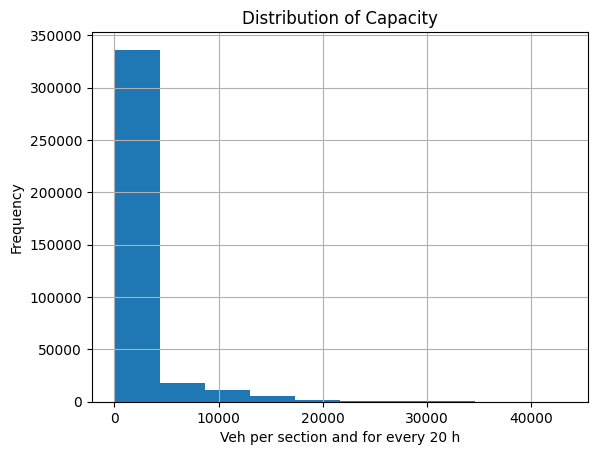

In [60]:
import matplotlib.pyplot as plt

objDFs['Links']['CAPPRT'].hist()
plt.xlabel('Veh per section and for every 20 h')
plt.ylabel('Frequency')
plt.title('Distribution of Capacity')

Text(0.5, 1.0, 'Distribution of Capacity')

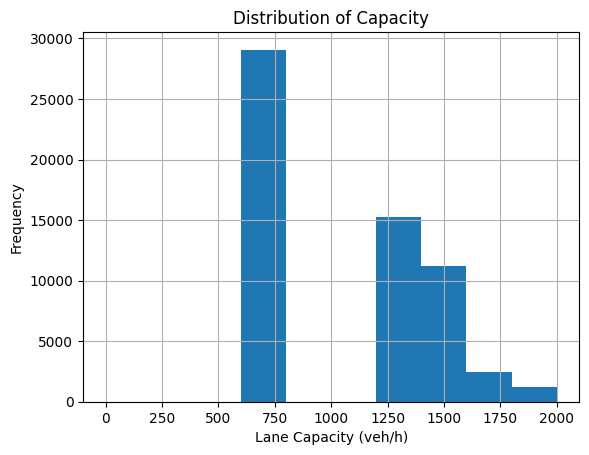

In [61]:
objDFs['Links']['CAPACIDAD'].hist()
plt.xlabel('Lane Capacity (veh/h)')
plt.ylabel('Frequency')
plt.title('Distribution of Capacity')

In [62]:
cap = objDFs['Links']['CAPACIDAD'].dropna()
cap [cap >0].sort_values()

186107     600.0
141893     600.0
141892     600.0
141891     600.0
141890     600.0
           ...  
350732    2000.0
357919    2000.0
184462    2000.0
338772    2000.0
291820    2000.0
Name: CAPACIDAD, Length: 59292, dtype: float64

* Replacing Capacity

In [63]:
objDFs['Links']['CAPPRT'] = objDFs['Links']['CAPACIDAD']

In [64]:
#get the nodes that are stop points

nd = list(objDFs['Stoppoints']['NO'].unique())


* removing only walk links not associated with stops and filtering links with less than 1000 veh/h of capacity.


In [65]:
objDFs['Links'] = objDFs['Links'].query('@nd in FROMNODENO |' +
                                         '@nd in TONODENO |' +
                                         'TSYSSET != "W" ' 
                                         )
#removing nulls values
objDFs['Links'] = objDFs['Links'][~objDFs['Links']['TSYSSET'].isnull()]
#displaye head
objDFs['Links']



NO  FROMNODENO  TONODENO  NAME  TYPENO  \
0            1      107820    107948   NaN       0   
1            1      107948    107820   NaN      91   
4            3        2329      2330   NaN       0   
5            3        2330      2329   NaN      90   
10           6        2335      2336   NaN      90   
...        ...         ...       ...   ...     ...   
376313  201549      140382    131119   NaN       0   
376316  201553      116460    140834   NaN      94   
376317  201553      140834    116460   NaN      94   
376318  201554      140287    140834   NaN      94   
376319  201554      140834    140287   NaN      94   

                               TSYSSET  USERDIRECTION    LENGTH  NUMLANES  \
0                                    W              0   0.503km         0   
1          Ca1_C,W,R,Auto_C,Cu_C,Ca2_C              1   0.503km         2   
4                                    W              0   0.263km         0   
5          Ca1_C,W,R,Auto_C,Cu_C,Ca2_C              1   0.263km         2   
10      Ca1_C,Al,W,R,Auto_C,Cu_C,Ca2_C              0   0.332km         1   
...                                ...            ...       ...       ...   
376313                      W,R,Auto_C              1   0.044km         1   
376316         Cu_C,Ca1_C,Ca2_C,Auto_C              0  11.980km         3   
376317         Cu_C,Ca1_C,Ca2_C,Auto_C              1  11.980km         3   
376318         Cu_C,Ca1_C,Ca2_C,Auto_C              0   6.652km         3   
376319         Cu_C,Ca1_C,Ca2_C,Auto_C              1   6.652km         3   

        PLANNO  ...  TYPE_LINK_CGA TYPE_LINK_PRV VEL_CGA VEL_FLUJO VEL_PRV  \
0            0  ...             99             0     0.0         0     NaN   
1            0  ...             99            91    22.0        40    30.0   
4            0  ...             99             0     0.0         0     NaN   
5            0  ...             99            90    19.0        30    28.0   
10           0  ...             99            90    33.0        30    33.0   
...        ...  ...            ...           ...     ...       ...     ...   
376313       0  ...             99             0     0.0        30     NaN   
376316       0  ...             99            94    60.0        80    60.0   
376317       0  ...             99            94    60.0        80    60.0   
376318       0  ...             99            94    60.0        80    60.0   
376319       0  ...             99            94    60.0        80    60.0   

       VEL_PUB VIALIDAD_PROY VOL_CAP VOL_TESC VOL_TPER\n  
0          NaN           NaN       0      0.0        0.0  
1       26.795           NaN       1      0.0        0.0  
4          NaN           0.0       0      0.0        0.0  
5       23.822           0.0       0      0.0        0.0  
10      22.787           NaN       0      0.0        0.0  
...        ...           ...     ...      ...        ...  
376313   0.000           NaN       0      0.0        0.0  
376316   0.000           0.0       1      0.0        0.0  
376317   0.000           0.0       1      0.0        0.0  
376318   0.000           0.0       1      0.0        0.0  
376319   0.000           0.0       1      0.0        0.0  

[72334 rows x 278 columns]

#### Cleaning other objects

* **Import, clean and prune non-stop nodes without links**

In [66]:
#display nodes
print(len(objDFs['Nodes']))
objDFs['Nodes'].head()

128975


NO  CODE  NAME  TYPENO  CONTROLTYPE  MAINNODENO  USEMETHODIMPATNODE  \
0  2327   NaN   NaN       0            0           0                   0   
1  2328   NaN   NaN       0            0           0                   0   
2  2329   NaN   NaN       0            0           0                   0   
3  2330   NaN   NaN       0            0           0                   0   
4  2331   NaN   NaN       0            0           0                   0   

   METHODIMPATNODE  AUTOLINKORIENTATION        XCOORD  ...  \
0                0                    1 -1.115252e+07  ...   
1                0                    1 -1.115252e+07  ...   
2                0                    1 -1.113956e+07  ...   
3                0                    1 -1.113952e+07  ...   
4                0                    1 -1.113499e+07  ...   

   ICAMETHODALLWAYSTOP  ICAMETHODROUNDABOUT  ICAMETHODSIGNALIZED  \
0             HCM 2010             HCM 2010             HCM 2010   
1             HCM 2010             HCM 2010             HCM 2010   
2             HCM 2010             HCM 2010             HCM 2010   
3             HCM 2010             HCM 2010             HCM 2010   
4             HCM 2010             HCM 2010             HCM 2010   

   ICAMETHODTWOWAYSTOP  VISTRODOANALYSIS SIGNALWARRANTPOPISBELOW10000  \
0             HCM 2010                 0                            0   
1             HCM 2010                 0                            0   
2             HCM 2010                 0                            0   
3             HCM 2010                 0                            0   
4             HCM 2010                 0                            0   

   ICAPEDESTRIANWALKINGSPEED  ICARIGHTTURNPEDESTRIANFACTOR ICACONFIDENCELEVEL  \
0                      4km/h                       Toronto               0.95   
1                      4km/h                       Toronto               0.95   
2                      4km/h                       Toronto               0.95   
3                      4km/h                       Toronto               0.95   
4                      4km/h                       Toronto               0.95   

   ICASHAREOFCAVS\n  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 45 columns]

In [67]:
#display stop points
print(len(objDFs['Stoppoints']))
objDFs['Stoppoints'].head()

4842


NO  STOPAREANO  CODE  NAME  TYPENO TSYSSET  DIRECTED  NODENO  FROMNODENO  \
0  2329        2329  2329   NaN       0       R         0    2329         NaN   
1  2330        2330  2330   NaN       0       R         0    2330         NaN   
2  2336        2336  2336   NaN       0    R,Al         0    2336         NaN   
3  2354        2354  2354   NaN       0       R         0    2354         NaN   
4  2363        2363  2363   NaN       0       R         0    2363         NaN   

   LINKNO  ...  DEFDWELLTIME  DEPOTVEHCOMBSET  DEPOTCAP(1)  \
0     NaN  ...            0s              NaN            0   
1     NaN  ...            0s              NaN            0   
2     NaN  ...            0s              NaN            0   
3     NaN  ...            0s              NaN            0   
4     NaN  ...            0s              NaN            0   

   DEPOTMINLAYOVERTIME(1)  DEPOTVEHCOMBSTANDARD  DEPOTCAPSTANDARD  \
0                      0s                     0                 0   
1                      0s                     0                 0   
2                      0s                     0                 0   
3                      0s                     0                 0   
4                      0s                     0                 0   

  DEPOTMINLAYOVERTIMESTANDARD  COSTRATE1  COSTRATE2 COSTRATE3\n  
0                          0s        0.0        0.0         0.0  
1                          0s        0.0        0.0         0.0  
2                          0s        0.0        0.0         0.0  
3                          0s        0.0        0.0         0.0  
4                          0s        0.0        0.0         0.0  

[5 rows x 26 columns]

In [68]:
#get the different nodes in the cleaned network
n1 = list(objDFs['Links'] ['FROMNODENO'].unique())
n2 = list(objDFs['Links'] ['TONODENO'].unique())
#get the union
n = set(n1).union(set(n2))
#filter non stop nodes without links
objDFs['Nodes'] = objDFs['Nodes'].query('@n in NO | @nd in NO')
objDFs['Nodes']

NO  CODE  NAME  TYPENO  CONTROLTYPE  MAINNODENO  \
2         2329   NaN   NaN       0            0           0   
3         2330   NaN   NaN       0            0           0   
8         2335   NaN   NaN       0            0           0   
9         2336   NaN   NaN       0            0           0   
10        2337   NaN   NaN       0            0           0   
...        ...   ...   ...     ...          ...         ...   
128936  140810   NaN   NaN       0            0           0   
128937  140811   NaN   NaN       0            0           0   
128942  140816   NaN   NaN       0            0           0   
128943  140817   NaN   NaN       0            0           0   
128960  140834   NaN   NaN       0            0           0   

        USEMETHODIMPATNODE  METHODIMPATNODE  AUTOLINKORIENTATION  \
2                        0                0                    1   
3                        0                0                    1   
8                        0                0                    1   
9                        0                0                    1   
10                       0                0                    1   
...                    ...              ...                  ...   
128936                   0                0                    1   
128937                   0                0                    1   
128942                   0                0                    1   
128943                   0                0                    1   
128960                   0                0                    1   

              XCOORD  ...  ICAMETHODALLWAYSTOP  ICAMETHODROUNDABOUT  \
2      -1.113956e+07  ...             HCM 2010             HCM 2010   
3      -1.113952e+07  ...             HCM 2010             HCM 2010   
8      -1.113530e+07  ...             HCM 2010             HCM 2010   
9      -1.113493e+07  ...             HCM 2010             HCM 2010   
10     -1.116986e+07  ...             HCM 2010             HCM 2010   
...              ...  ...                  ...                  ...   
128936 -1.116174e+07  ...             HCM 2010             HCM 2010   
128937 -1.115564e+07  ...             HCM 2010             HCM 2010   
128942 -1.112689e+07  ...             HCM 2010             HCM 2010   
128943 -1.113081e+07  ...             HCM 2010             HCM 2010   
128960 -1.112138e+07  ...             HCM 2010             HCM 2010   

        ICAMETHODSIGNALIZED  ICAMETHODTWOWAYSTOP  VISTRODOANALYSIS  \
2                  HCM 2010             HCM 2010                 0   
3                  HCM 2010             HCM 2010                 0   
8                  HCM 2010             HCM 2010                 0   
9                  HCM 2010             HCM 2010                 0   
10                 HCM 2010             HCM 2010                 0   
...                     ...                  ...               ...   
128936             HCM 2010             HCM 2010                 0   
128937             HCM 2010             HCM 2010                 0   
128942             HCM 2010             HCM 2010                 0   
128943             HCM 2010             HCM 2010                 0   
128960             HCM 2010             HCM 2010                 0   

       SIGNALWARRANTPOPISBELOW10000  ICAPEDESTRIANWALKINGSPEED  \
2                                 0                      4km/h   
3                                 0                      4km/h   
8                                 0                      4km/h   
9                                 0                      4km/h   
10                                0                      4km/h   
...                             ...                        ...   
128936                            0                      4km/h   
128937                            0                      4km/h   
128942                            0                      4km/h   
128943                            0                      4km/h   
128960            

* **From Turns clean nonstop nodes without links**

In [69]:
#display turns
print(len(objDFs['Turns']))
objDFs['Turns'].head()


805646


FROMNODENO  VIANODENO  TONODENO  TYPENO                    TSYSSET  CAPPRT  \
0      107820     107948    107798       3    Cu_C,Ca1_C,Ca2_C,Auto_C   99999   
1      107820     107948    107819       2    Cu_C,Ca1_C,Ca2_C,Auto_C   99999   
3      107820     107948    137441       1    Cu_C,Ca1_C,Ca2_C,Auto_C   99999   
4      107948     107820    107813       2  Ca1_C,R,Auto_C,Cu_C,Ca2_C   99999   
6      107948     107820    108062       1    Cu_C,Ca1_C,Ca2_C,Auto_C   99999   

  T0PRT  ADDVAL1  ADDVAL2  ADDVAL3  ...  \
0    0s        0        0        0  ...   
1    0s        0        0        0  ...   
3    0s        0        0        0  ...   
4    0s        0        0        0  ...   
6    0s        0        0        0  ...   

  VISTROTURNONREDVOLUMECALCULATIONMETHOD  VISTROLRORDERNO  \
0                          ABSOLUTEVALUE                0   
1                          ABSOLUTEVALUE                0   
3                          ABSOLUTEVALUE                0   
4                          ABSOLUTEVALUE                0   
6                          ABSOLUTEVALUE                0   

  VISTROOTHERADJUSTFACTOR  VISTROLANEWIDTH USEVISTROLANEWIDTH  \
0                     1.0            3.50m                  0   
1                     1.0            3.50m                  0   
3                     1.0            3.50m                  0   
4                     1.0            3.50m                  0   
6                     1.0            3.50m                  0   

   VISTROOUTERCONTROL VISTROTHRUCONTROL  VISTROINNERCONTROL  VISTROSGNO  \
0          PERMISSIVE        PERMISSIVE          PERMISSIVE           0   
1          PERMISSIVE        PERMISSIVE          PERMISSIVE           0   
3          PERMISSIVE        PERMISSIVE          PERMISSIVE           0   
4          PERMISSIVE        PERMISSIVE          PERMISSIVE           0   
6          PERMISSIVE        PERMISSIVE          PERMISSIVE           0   

   VISTROOVLNO\n  
0              0  
1              0  
3              0  
4              0  
6              0  

[5 rows x 66 columns]

In [70]:
#filter non stop turns without links
objDFs['Turns'] = objDFs['Turns'].query('@n in (FROMNODENO | VIANODENO | TONODENO) | @nd in (FROMNODENO | VIANODENO | TONODENO)')
objDFs['Turns']

FROMNODENO  VIANODENO  TONODENO  TYPENO                    TSYSSET  \
1            107820     107948    107819       2    Cu_C,Ca1_C,Ca2_C,Auto_C   
4            107948     107820    107813       2  Ca1_C,R,Auto_C,Cu_C,Ca2_C   
10             2328       2327      3393       1    Cu_C,Ca1_C,Ca2_C,Auto_C   
17             2330       2329     38463       3    Cu_C,Ca1_C,Ca2_C,Auto_C   
18             2330       2329     38543       1  Ca1_C,R,Auto_C,Cu_C,Ca2_C   
...             ...        ...       ...     ...                        ...   
1182055       71203      71219     70787       3    Cu_C,Ca1_C,Ca2_C,Auto_C   
1182057       71203      71219     71203       4    Cu_C,Ca1_C,Ca2_C,Auto_C   
1182060       71219      71203     71206       2    Cu_C,Ca1_C,Ca2_C,Auto_C   
1182120       47351      47354     47557       3    Cu_C,Ca1_C,Ca2_C,Auto_C   
1182121       47351      47354     47558       2    Cu_C,Ca1_C,Ca2_C,Auto_C   

         CAPPRT T0PRT  ADDVAL1  ADDVAL2  ADDVAL3  ...  \
1         99999    0s        0        0        0  ...   
4         99999    0s        0        0        0  ...   
10        99999    0s        0        0        0  ...   
17        99999    0s        0        0        0  ...   
18        99999    0s        0        0        0  ...   
...         ...   ...      ...      ...      ...  ...   
1182055   99999    0s        0        0        0  ...   
1182057   99999    0s        0        0        0  ...   
1182060   99999    0s        0        0        0  ...   
1182120   99999    0s        0        0        0  ...   
1182121   99999    0s        0        0        0  ...   

        VISTROTURNONREDVOLUMECALCULATIONMETHOD  VISTROLRORDERNO  \
1                                ABSOLUTEVALUE                0   
4                                ABSOLUTEVALUE                0   
10                               ABSOLUTEVALUE                0   
17                               ABSOLUTEVALUE                0   
18                               ABSOLUTEVALUE                0   
...                                        ...              ...   
1182055                          ABSOLUTEVALUE                0   
1182057                          ABSOLUTEVALUE                0   
1182060                          ABSOLUTEVALUE                0   
1182120                          ABSOLUTEVALUE                0   
1182121                          ABSOLUTEVALUE                0   

        VISTROOTHERADJUSTFACTOR  VISTROLANEWIDTH USEVISTROLANEWIDTH  \
1                           1.0            3.50m                  0   
4                           1.0            3.50m                  0   
10                          1.0            3.50m                  0   
17                          1.0            3.50m                  0   
18                          1.0            3.50m                  0   
...                         ...              ...                ...   
1182055                     1.0            3.50m                  0   
1182057                     1.0            3.50m                  0   
1182060                     1.0            3.50m                  0   
1182120                     1.0            3.50m                  0   
1182121                     1.0            3.50m                  0   

         VISTROOUTERCONTROL VISTROTHRUCONTROL  VISTROINNERCONTROL  VISTROSGNO  \
1                PERMISSIVE        PERMISSIVE          PERMISSIVE           0   
4                PERMISSIVE        PERMISSIVE          PERMISSIVE           0   
10               PERMISSIVE        PERMISSIVE          PERMISSIVE           0   
17               PERMISSIVE        PERMISSIVE          PERMISSIVE           0   
18               PERMISSIVE        PERMISSIVE          PERMISSIVE           0   
...                     ...               ...                 ...         ...   
1182055          PERMISSIVE        PERMISSIVE          PERMISSIVE           0   
1182057          PERMISSIVE        PERMISSIVE          PERMISSIVE    

* **clean non stop connectors without links**

In [71]:
#display turns
print(len(objDFs['Connectors']))
objDFs['Connectors'].head()


5187


ZONENO  NODENO DIRECTION  TYPENO                    TSYSSET   LENGTH  \
0       1   15995         O       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   
1       1   15995         D       0  Ca1_C,W,Auto_C,Cu_C,Ca2_C  0.200km   
2       1   17911         O       0           Cu_C,Ca1_C,Ca2_C  0.200km   
3       1   17911         D       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   
4       1   17919         O       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   

  T0_TSYS(AUTO_C) T0_TSYS(CA1_C) T0_TSYS(CA2_C) T0_TSYS(CA_BD)  ...  \
0             24s             0s             0s             0s  ...   
1             24s             0s             0s             0s  ...   
2             24s             0s             0s             0s  ...   
3             24s             0s             0s             0s  ...   
4             24s             0s             0s             0s  ...   

  T0_TSYS(CU_C) T0_TSYS(W) WEIGHT(PRT)  WEIGHT(PUT)  ADDVAL1  ADDVAL2  \
0            0s       120s           1            1        0        0   
1            0s       120s           1            1        0        0   
2            0s       120s           1            1        0        0   
3            0s       120s           1            1        0        0   
4            0s       120s           1            1        0        0   

   ADDVAL3  LABELPOSRELX  LABELPOSRELY  EXPORTADO\n  
0        0           0.0           0.0            0  
1        0           0.0           0.0            0  
2        0           0.0           0.0            1  
3        0           0.0           0.0            1  
4        0           0.0           0.0            0  

[5 rows x 21 columns]

In [72]:
#filter non stop connectors without links
objDFs['Connectors'] = objDFs['Connectors'].query('@n in NODENO | @nd in NODENO')
objDFs['Connectors']

ZONENO  NODENO DIRECTION  TYPENO                    TSYSSET   LENGTH  \
0          1   15995         O       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   
1          1   15995         D       0  Ca1_C,W,Auto_C,Cu_C,Ca2_C  0.200km   
2          1   17911         O       0           Cu_C,Ca1_C,Ca2_C  0.200km   
3          1   17911         D       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   
4          1   17919         O       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   
...      ...     ...       ...     ...                        ...      ...   
5197     999  116337         D       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   
5198     999  133489         O       0                          W  0.200km   
5199     999  133489         D       0                          W  0.200km   
5200     999  134362         O       0  Ca1_C,W,Auto_C,Cu_C,Ca2_C  0.200km   
5201     999  134362         D       0  Ca1_C,W,Auto_C,Cu_C,Ca2_C  0.200km   

     T0_TSYS(AUTO_C) T0_TSYS(CA1_C) T0_TSYS(CA2_C) T0_TSYS(CA_BD)  ...  \
0                24s             0s             0s             0s  ...   
1                24s             0s             0s             0s  ...   
2                24s             0s             0s             0s  ...   
3                24s             0s             0s             0s  ...   
4                24s             0s             0s             0s  ...   
...              ...            ...            ...            ...  ...   
5197             24s         11116s             0s             0s  ...   
5198              0s             0s             0s             0s  ...   
5199              0s             0s             0s             0s  ...   
5200             24s             0s             0s             0s  ...   
5201             24s             0s             0s             0s  ...   

     T0_TSYS(CU_C) T0_TSYS(W) WEIGHT(PRT)  WEIGHT(PUT)  ADDVAL1  ADDVAL2  \
0               0s       120s           1            1        0        0   
1               0s       120s           1            1        0        0   
2               0s       120s           1            1        0        0   
3               0s       120s           1            1        0        0   
4               0s       120s           1            1        0        0   
...            ...        ...         ...          ...      ...      ...   
5197        11116s       120s           4            1        0        0   
5198            0s       120s           1            1        0        0   
5199            0s       120s           1            1        0        0   
5200            0s       120s          10            1        0        0   
5201            0s       120s          60            1        0        0   

      ADDVAL3  LABELPOSRELX  LABELPOSRELY  EXPORTADO\n  
0           0           0.0           0.0            0  
1           0           0.0           0.0            0  
2           0           0.0           0.0            1  
3           0           0.0           0.0            1  
4           0           0.0           0.0            0  
...       ...           ...           ...          ...  
5197        0           0.0           0.0            1  
5198        0           0.0           0.0            0  
5199        0           0.0           0.0            0  
5200        0           0.0           0.0            0  
5201        0           0.0           0.0            0  

[4651 rows x 21 columns]

In [73]:
#display zones
print(len(objDFs['Zones']))
objDFs['Zones'].head()

766


NO  CODE  NAME  MAINZONENO  TYPENO        XCOORD        YCOORD  SURFACEID  \
0   1     0   NaN          13       0 -1.115399e+07  2.954884e+06          1   
1   2     0   NaN          13       0 -1.115375e+07  2.956130e+06          2   
2   3     0   NaN          13       0 -1.115570e+07  2.955264e+06          3   
3   4     0   NaN          14       0 -1.115135e+07  2.955678e+06          4   
4   5     0   NaN          14       0 -1.115217e+07  2.956862e+06          5   

   RELATIVESTATE  SHAREPRTORIG  ...  TXMOT_2030  TXMOT_2030_DOMS  TXMOT_2035  \
0              0             0  ...     550.956          541.727     583.665   
1              0             0  ...     550.956          541.727     583.665   
2              0             0  ...     550.956          541.727     583.665   
3              0             0  ...     550.956          541.727     583.665   
4              0             0  ...     550.956          541.727     583.665   

   TXMOT_2035_DOMS  TXMOT_2040  TXMOT_2040_DOMS  TXMOT_2045  TXMOT_2045_DOMS  \
0          568.782      609.15          588.287     628.488          601.463   
1          568.782      609.15          588.287     628.488          601.463   
2          568.782      609.15          588.287     628.488          601.463   
3          568.782      609.15          588.287     628.488          601.463   
4          568.782      609.15          588.287     628.488          601.463   

   TXMOT_2050  TXMOT_2050_DOMS\n  
0     642.869            609.601  
1     642.869            609.601  
2     642.869            609.601  
3     642.869            609.601  
4     642.869            609.601  

[5 rows x 103 columns]

In [74]:
#validate that each zone has at least 1 connector
zones_c = objDFs['Connectors'].ZONENO.unique()
print(f"Zones: {len(objDFs['Zones'].NO)}")
diff_zones = set(objDFs['Zones'].NO) - set(zones_c)
if len(diff_zones) > 0: print(f"These zones does not have connectors: {diff_zones}")
else:  print('All zones have at least one connector')

Zones: 766
All zones have at least one connector


In [75]:
objDFs['Nodes']

NO  CODE  NAME  TYPENO  CONTROLTYPE  MAINNODENO  \
2         2329   NaN   NaN       0            0           0   
3         2330   NaN   NaN       0            0           0   
8         2335   NaN   NaN       0            0           0   
9         2336   NaN   NaN       0            0           0   
10        2337   NaN   NaN       0            0           0   
...        ...   ...   ...     ...          ...         ...   
128936  140810   NaN   NaN       0            0           0   
128937  140811   NaN   NaN       0            0           0   
128942  140816   NaN   NaN       0            0           0   
128943  140817   NaN   NaN       0            0           0   
128960  140834   NaN   NaN       0            0           0   

        USEMETHODIMPATNODE  METHODIMPATNODE  AUTOLINKORIENTATION  \
2                        0                0                    1   
3                        0                0                    1   
8                        0                0                    1   
9                        0                0                    1   
10                       0                0                    1   
...                    ...              ...                  ...   
128936                   0                0                    1   
128937                   0                0                    1   
128942                   0                0                    1   
128943                   0                0                    1   
128960                   0                0                    1   

              XCOORD  ...  ICAMETHODALLWAYSTOP  ICAMETHODROUNDABOUT  \
2      -1.113956e+07  ...             HCM 2010             HCM 2010   
3      -1.113952e+07  ...             HCM 2010             HCM 2010   
8      -1.113530e+07  ...             HCM 2010             HCM 2010   
9      -1.113493e+07  ...             HCM 2010             HCM 2010   
10     -1.116986e+07  ...             HCM 2010             HCM 2010   
...              ...  ...                  ...                  ...   
128936 -1.116174e+07  ...             HCM 2010             HCM 2010   
128937 -1.115564e+07  ...             HCM 2010             HCM 2010   
128942 -1.112689e+07  ...             HCM 2010             HCM 2010   
128943 -1.113081e+07  ...             HCM 2010             HCM 2010   
128960 -1.112138e+07  ...             HCM 2010             HCM 2010   

        ICAMETHODSIGNALIZED  ICAMETHODTWOWAYSTOP  VISTRODOANALYSIS  \
2                  HCM 2010             HCM 2010                 0   
3                  HCM 2010             HCM 2010                 0   
8                  HCM 2010             HCM 2010                 0   
9                  HCM 2010             HCM 2010                 0   
10                 HCM 2010             HCM 2010                 0   
...                     ...                  ...               ...   
128936             HCM 2010             HCM 2010                 0   
128937             HCM 2010             HCM 2010                 0   
128942             HCM 2010             HCM 2010                 0   
128943             HCM 2010             HCM 2010                 0   
128960             HCM 2010             HCM 2010                 0   

       SIGNALWARRANTPOPISBELOW10000  ICAPEDESTRIANWALKINGSPEED  \
2                                 0                      4km/h   
3                                 0                      4km/h   
8                                 0                      4km/h   
9                                 0                      4km/h   
10                                0                      4km/h   
...                             ...                        ...   
128936                            0                      4km/h   
128937                            0                      4km/h   
128942                            0                      4km/h   
128943                            0                      4km/h   
128960            

### **Normalize network with TMG coding standard**

#####  **Centroids of Zones and Nodes**

Transform the numbering of the centroids for each zone and node according to the TMG standard convention.

In [76]:
objDFs['Zones'].head()

NO  CODE  NAME  MAINZONENO  TYPENO        XCOORD        YCOORD  SURFACEID  \
0   1     0   NaN          13       0 -1.115399e+07  2.954884e+06          1   
1   2     0   NaN          13       0 -1.115375e+07  2.956130e+06          2   
2   3     0   NaN          13       0 -1.115570e+07  2.955264e+06          3   
3   4     0   NaN          14       0 -1.115135e+07  2.955678e+06          4   
4   5     0   NaN          14       0 -1.115217e+07  2.956862e+06          5   

   RELATIVESTATE  SHAREPRTORIG  ...  TXMOT_2030  TXMOT_2030_DOMS  TXMOT_2035  \
0              0             0  ...     550.956          541.727     583.665   
1              0             0  ...     550.956          541.727     583.665   
2              0             0  ...     550.956          541.727     583.665   
3              0             0  ...     550.956          541.727     583.665   
4              0             0  ...     550.956          541.727     583.665   

   TXMOT_2035_DOMS  TXMOT_2040  TXMOT_2040_DOMS  TXMOT_2045  TXMOT_2045_DOMS  \
0          568.782      609.15          588.287     628.488          601.463   
1          568.782      609.15          588.287     628.488          601.463   
2          568.782      609.15          588.287     628.488          601.463   
3          568.782      609.15          588.287     628.488          601.463   
4          568.782      609.15          588.287     628.488          601.463   

   TXMOT_2050  TXMOT_2050_DOMS\n  
0     642.869            609.601  
1     642.869            609.601  
2     642.869            609.601  
3     642.869            609.601  
4     642.869            609.601  

[5 rows x 103 columns]

In [77]:
objDFs['Nodes'].head()

NO  CODE  NAME  TYPENO  CONTROLTYPE  MAINNODENO  USEMETHODIMPATNODE  \
2   2329   NaN   NaN       0            0           0                   0   
3   2330   NaN   NaN       0            0           0                   0   
8   2335   NaN   NaN       0            0           0                   0   
9   2336   NaN   NaN       0            0           0                   0   
10  2337   NaN   NaN       0            0           0                   0   

    METHODIMPATNODE  AUTOLINKORIENTATION        XCOORD  ...  \
2                 0                    1 -1.113956e+07  ...   
3                 0                    1 -1.113952e+07  ...   
8                 0                    1 -1.113530e+07  ...   
9                 0                    1 -1.113493e+07  ...   
10                0                    1 -1.116986e+07  ...   

    ICAMETHODALLWAYSTOP  ICAMETHODROUNDABOUT  ICAMETHODSIGNALIZED  \
2              HCM 2010             HCM 2010             HCM 2010   
3              HCM 2010             HCM 2010             HCM 2010   
8              HCM 2010             HCM 2010             HCM 2010   
9              HCM 2010             HCM 2010             HCM 2010   
10             HCM 2010             HCM 2010             HCM 2010   

    ICAMETHODTWOWAYSTOP  VISTRODOANALYSIS SIGNALWARRANTPOPISBELOW10000  \
2              HCM 2010                 0                            0   
3              HCM 2010                 0                            0   
8              HCM 2010                 0                            0   
9              HCM 2010                 0                            0   
10             HCM 2010                 0                            0   

    ICAPEDESTRIANWALKINGSPEED  ICARIGHTTURNPEDESTRIANFACTOR  \
2                       4km/h                       Toronto   
3                       4km/h                       Toronto   
8                       4km/h                       Toronto   
9                       4km/h                       Toronto   
10                      4km/h                       Toronto   

   ICACONFIDENCELEVEL  ICASHAREOFCAVS\n  
2                0.95               0.0  
3                0.95               0.0  
8                0.95               0.0  
9                0.95               0.0  
10               0.95               0.0  

[5 rows x 45 columns]

* Importing polygons of each municipality

In [78]:
poly_NL = geopandas.read_file(glob('poly_mun_NL/*.shp')[0])
poly_NL.head(2)

CVEGEO CVE_ENT CVE_MUN          NOMGEO  \
0  19038      19     038    Montemorelos   
1  19025      19     025  General Zuazua   

                                            geometry  
0  POLYGON ((406805.368 2811371.835, 406896.740 2...  
1  POLYGON ((393097.934 2875312.008, 393622.185 2...

* Importing populations of each municipality

In [79]:
pob_NL = pd.read_csv('pob_NL.csv')
pob_NL = pob_NL.drop(columns=['CVE_MUN'])
pob_NL.head(2)

NOMGEO   POB_2020
0  Monterrey  1,142,994
1    Apodaca    656,464

* Merging population and polygons DF

In [80]:
poly_pob_NL = pd.merge(poly_NL, pob_NL, how="inner", on=["NOMGEO"])
poly_pob_NL.head(2)

CVEGEO CVE_ENT CVE_MUN          NOMGEO  \
0  19038      19     038    Montemorelos   
1  19025      19     025  General Zuazua   

                                            geometry POB_2020  
0  POLYGON ((406805.368 2811371.835, 406896.740 2...   67,428  
1  POLYGON ((393097.934 2875312.008, 393622.185 2...  102,149

* Converting zones and nodes DF to geospatial DF and projecting to same crs.

In [81]:

zones = geopandas.GeoDataFrame(objDFs['Zones'],
                               crs="EPSG:3857",
                               geometry=geopandas.points_from_xy(objDFs['Zones']['XCOORD'],
                                                                 objDFs['Zones']['YCOORD']))
nodes = geopandas.GeoDataFrame(objDFs['Nodes'],
                               crs="EPSG:3857",
                               geometry=geopandas.points_from_xy(objDFs['Nodes']['XCOORD'],
                                                                 objDFs['Nodes']['YCOORD']))

poly_pob_NL = poly_pob_NL.to_crs(zones.crs)
poly_pob_NL.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [82]:
m = zones.explore(color='red')
#nodes.explore(m=m, color= 'green')
poly_pob_NL.explore(m =m)

* Spatial joint, sorting and concating zones

In [83]:
import json

# Spatial joint, sorting and concating zones
zonesInPoly = geopandas.sjoin(zones, poly_pob_NL, op='within')
zones_sorted = zonesInPoly.sort_values('POB_2020_right').drop(['geometry','index_right','CVEGEO','CVE_ENT','CVE_MUN','NOMGEO','POB_2020_right'],axis=1)
zones_sorted_concat = pd.concat([zones_sorted, objDFs['Zones']]).drop(['POB_2020'],axis=1).drop_duplicates('NO').reset_index(drop=True)
mapping_zones_dict = {k: v for k,v in zip(zones_sorted_concat['NO'].to_list(),
                                          range(1, len(objDFs['Zones'])+1)
                                         )
                     }
zones_sorted_concat.head()
#export map of zones to json
json_obj = json.dumps(mapping_zones_dict)
with open ('zones_mapping.json', 'w') as f:
    f.write(json_obj)
f.close()

/home/alan/anaconda3/envs/rapids/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


* Spatial joint, sorting and concating nodes

In [84]:
# Spatial joint, sorting and concating zones
nodesInPoly = geopandas.sjoin(nodes, poly_pob_NL, op='within')
nodes_sorted = nodesInPoly.sort_values('POB_2020').drop(['geometry','index_right','CVEGEO','CVE_ENT','CVE_MUN','NOMGEO','POB_2020'],axis=1)
nodes_sorted_concat = pd.concat([nodes_sorted, objDFs['Nodes']]).drop_duplicates('NO').reset_index(drop=True)
mapping_nodes_dict = {k: v for k,v in zip(nodes_sorted_concat['NO'].to_list(),
                                          range(1, len(objDFs['Nodes'])+1)
                                         )
                     }
nodes_sorted_concat.head()

#export map of nodes to json
json_obj = json.dumps(mapping_nodes_dict)
with open ('nodes_mapping.json', 'w') as f:
    f.write(json_obj)
f.close()

/home/alan/anaconda3/envs/rapids/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [85]:
zones_sorted_concat['NO'] = zones_sorted_concat.index + 1
nodes_sorted_concat['NO'] = nodes_sorted_concat.index + 1

In [86]:
objDFs['Zones'] = zones_sorted_concat
objDFs['Zones']

NO  CODE  NAME  MAINZONENO  TYPENO        XCOORD        YCOORD  \
0      1     0   NaN         172       0 -1.116726e+07  2.953641e+06   
1      2     0   NaN         172       0 -1.116732e+07  2.956060e+06   
2      3     0   NaN         172       0 -1.116656e+07  2.957128e+06   
3      4     0   NaN         181       0 -1.118027e+07  2.966488e+06   
4      5     0   NaN          21       0 -1.116096e+07  2.951806e+06   
..   ...   ...   ...         ...     ...           ...           ...   
761  762     0   NaN           0       0 -1.104319e+07  2.829871e+06   
762  763     0   NaN           0       0 -1.125633e+07  3.067590e+06   
763  764     0   NaN           0       0 -1.121632e+07  2.951314e+06   
764  765     0   NaN           0       0 -1.132276e+07  2.788263e+06   
765  766     0   NaN           0       0 -1.099460e+07  3.076669e+06   

     SURFACEID  RELATIVESTATE  SHAREPRTORIG  ...  TXMOT_2030  TXMOT_2030_DOMS  \
0          126              0             0  ...     342.585          336.847   
1          115              0             0  ...     342.585          336.847   
2          114              0             0  ...     342.585          336.847   
3          113              0             0  ...     129.461          127.292   
4          108              0             0  ...     801.847          788.416   
..         ...            ...           ...  ...         ...              ...   
761        755              0             0  ...       0.000            0.000   
762        757              0             1  ...       0.000            0.000   
763        758              0             0  ...       0.000            0.000   
764        760              0             0  ...       0.000            0.000   
765        766              0             1  ...       0.000            0.000   

     TXMOT_2035  TXMOT_2035_DOMS  TXMOT_2040  TXMOT_2040_DOMS  TXMOT_2045  \
0       373.023          363.511     399.305          385.629     421.295   
1       373.023          363.511     399.305          385.629     421.295   
2       373.023          363.511     399.305          385.629     421.295   
3       133.719          130.310     136.306          131.638     137.845   
4       810.884          790.206     815.448          787.519     817.733   
..          ...              ...         ...              ...         ...   
761       0.000            0.000       0.000            0.000       0.000   
762       0.000            0.000       0.000            0.000       0.000   
763       0.000            0.000       0.000            0.000       0.000   
764       0.000            0.000       0.000            0.000       0.000   
765       0.000            0.000       0.000            0.000       0.000   

     TXMOT_2045_DOMS  TXMOT_2050  TXMOT_2050_DOMS\n  
0            403.180     439.214            416.485  
1            403.180     439.214            416.485  
2            403.180     439.214            416.485  
3            131.918     138.748            131.568  
4            782.570     818.873            776.496  
..               ...         ...                ...  
761            0.000       0.000              0.000  
762            0.000       0.000              0.000  
763            0.000       0.000              0.000  
764            0.000       0.000              0.000  
765            0.000       0.000              0.000  

[766 rows x 103 columns]

In [87]:
objDFs['Nodes'] = nodes_sorted_concat
objDFs['Nodes'].head()

NO  CODE  NAME  TYPENO  CONTROLTYPE  MAINNODENO  USEMETHODIMPATNODE  \
0   1   NaN   NaN       0            0           0                   0   
1   2   NaN   NaN       0            0           0                   0   
2   3   NaN   NaN       0            0           0                   0   
3   4   NaN   NaN       0            0           0                   0   
4   5   NaN   NaN       0            0           0                   0   

   METHODIMPATNODE  AUTOLINKORIENTATION        XCOORD  ...  \
0                0                    1 -1.116467e+07  ...   
1                0                    1 -1.117046e+07  ...   
2                0                    1 -1.117051e+07  ...   
3                0                    1 -1.117047e+07  ...   
4                0                    1 -1.117048e+07  ...   

   ICAMETHODALLWAYSTOP  ICAMETHODROUNDABOUT  ICAMETHODSIGNALIZED  \
0             HCM 2010             HCM 2010             HCM 2010   
1             HCM 2010             HCM 2010             HCM 2010   
2             HCM 2010             HCM 2010             HCM 2010   
3             HCM 2010             HCM 2010             HCM 2010   
4             HCM 2010             HCM 2010             HCM 2010   

   ICAMETHODTWOWAYSTOP  VISTRODOANALYSIS SIGNALWARRANTPOPISBELOW10000  \
0             HCM 2010                 0                            0   
1             HCM 2010                 0                            0   
2             HCM 2010                 0                            0   
3             HCM 2010                 0                            0   
4             HCM 2010                 0                            0   

   ICAPEDESTRIANWALKINGSPEED  ICARIGHTTURNPEDESTRIANFACTOR ICACONFIDENCELEVEL  \
0                      4km/h                       Toronto               0.95   
1                      4km/h                       Toronto               0.95   
2                      4km/h                       Toronto               0.95   
3                      4km/h                       Toronto               0.95   
4                      4km/h                       Toronto               0.95   

   ICASHAREOFCAVS\n  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 45 columns]

* Exploring the impact of the changes in the objects

In [88]:
!grep -lR "ZONE"

network.net
.ipynb_checkpoints/preprocessing_pimus-checkpoint.ipynb
preprocessing_pimus.ipynb
Base_Network/Mainzones.csv
Base_Network/Zones.csv
Base_Network/User-definedattributes.csv
Base_Network/Connectors.csv
Base_Network/Tickettypes.csv
Base_Network/Links.csv


In [89]:
!grep -lR "NODE"

network.net
.ipynb_checkpoints/preprocessing_pimus-checkpoint.ipynb
preprocessing_pimus.ipynb
Base_Network/Turns.csv
Base_Network/Linerouteitems.csv
Base_Network/Stoppoints.csv
Base_Network/Connectors.csv
Base_Network/Stopareas.csv
Base_Network/Nodes.csv
Base_Network/Links.csv
Base_Network/Linkpolygons.csv


In [90]:
#mapping zones in connectors object

objDFs['Connectors']['ZONENO'] = objDFs['Connectors']['ZONENO'].map(mapping_zones_dict)
objDFs['Connectors']

ZONENO  NODENO DIRECTION  TYPENO                    TSYSSET   LENGTH  \
0        558   15995         O       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   
1        558   15995         D       0  Ca1_C,W,Auto_C,Cu_C,Ca2_C  0.200km   
2        558   17911         O       0           Cu_C,Ca1_C,Ca2_C  0.200km   
3        558   17911         D       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   
4        558   17919         O       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   
...      ...     ...       ...     ...                        ...      ...   
5197     766  116337         D       0    Cu_C,Ca1_C,Ca2_C,Auto_C  0.200km   
5198     766  133489         O       0                          W  0.200km   
5199     766  133489         D       0                          W  0.200km   
5200     766  134362         O       0  Ca1_C,W,Auto_C,Cu_C,Ca2_C  0.200km   
5201     766  134362         D       0  Ca1_C,W,Auto_C,Cu_C,Ca2_C  0.200km   

     T0_TSYS(AUTO_C) T0_TSYS(CA1_C) T0_TSYS(CA2_C) T0_TSYS(CA_BD)  ...  \
0                24s             0s             0s             0s  ...   
1                24s             0s             0s             0s  ...   
2                24s             0s             0s             0s  ...   
3                24s             0s             0s             0s  ...   
4                24s             0s             0s             0s  ...   
...              ...            ...            ...            ...  ...   
5197             24s         11116s             0s             0s  ...   
5198              0s             0s             0s             0s  ...   
5199              0s             0s             0s             0s  ...   
5200             24s             0s             0s             0s  ...   
5201             24s             0s             0s             0s  ...   

     T0_TSYS(CU_C) T0_TSYS(W) WEIGHT(PRT)  WEIGHT(PUT)  ADDVAL1  ADDVAL2  \
0               0s       120s           1            1        0        0   
1               0s       120s           1            1        0        0   
2               0s       120s           1            1        0        0   
3               0s       120s           1            1        0        0   
4               0s       120s           1            1        0        0   
...            ...        ...         ...          ...      ...      ...   
5197        11116s       120s           4            1        0        0   
5198            0s       120s           1            1        0        0   
5199            0s       120s           1            1        0        0   
5200            0s       120s          10            1        0        0   
5201            0s       120s          60            1        0        0   

      ADDVAL3  LABELPOSRELX  LABELPOSRELY  EXPORTADO\n  
0           0           0.0           0.0            0  
1           0           0.0           0.0            0  
2           0           0.0           0.0            1  
3           0           0.0           0.0            1  
4           0           0.0           0.0            0  
...       ...           ...           ...          ...  
5197        0           0.0           0.0            1  
5198        0           0.0           0.0            0  
5199        0           0.0           0.0            0  
5200        0           0.0           0.0            0  
5201        0           0.0           0.0            0  

[4651 rows x 21 columns]

#####  **Exporting Network**



* **Save dataframes as csv**

In [91]:
!mkdir output
for file in objDFs.keys():
    objDFs[file].to_csv('output/' + file + '.csv', index=False, float_format="%.3f")

* **Convert csv's to net file**

In [92]:
conv.csv2net('output/', 'output.net')

output.net


/home/alan/Downloads/Preparation-Network-for-GTAModel-Monterrey/Converters.py:145: DtypeWarning: Columns (242,266) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(tab_file)


* **compress output**

In [93]:
!rm -rf output
!rm output.zip
!zip output.zip output.net
!rm output.net

  adding: output.net (deflated 94%)


* **Remove Network folder with csvs**

In [94]:
!rm -rf Base_Network
!rm network.net